In [59]:
from typing import List, Tuple, Union
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import InputLayer, LSTM, GRU, Dense, Flatten, Conv1D
import keras
import glob
import os
from scipy.io.wavfile import read
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
import midiDriver
import audioRecorder


def esr(signal_a, signal_b) -> float:
    '''Returns the Error-to-Signal Ratio.

    Keyword arguments:
    signal_a -- the groundtruth signal
    signal_b -- the predicted signal
    '''
    power = 2.0
    numerator = np.sum(np.power(np.subtract(signal_a, signal_b), power))
    denominator = np.sum(np.power(signal_a, power))
    return np.divide(numerator, denominator)
    

def normalize(array: Union[List,ndarray], scale_max: int=1, scale_min: int=0) -> List:
    '''Returns a normalized array.
    
    Keyword arguments:
    array -- array to normalize
    scale_max -- maximum value to scale between
    scale_min -- minimum value to scale between

    Source: https://www.geeksforgeeks.org/how-to-normalize-an-array-in-numpy-in-python/
    '''
    scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
    return scaler.fit_transform(array)


def partition_dataset(data_path: str='data/simple_dataset/01/*', train_perc: float=0.8) -> Tuple[List, List, List, List]: 
    '''Partition into train, train_labels & test, test_labels datasets.

    Keyword arguments:
    data_path -- where the data lives
    '''
    assert train_perc < 1, 'train_perc must be less than 1'
    data_paths = glob.glob(data_path)
    split_idx = int(0.8 * len(data_paths))
    train_paths, test_paths = data_paths[:split_idx], data_paths[split_idx:]
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    for file in train_paths:
        _, data = read(file)
        train_data.append(data)
        train_labels.append(os.path.basename(file).split('.')[0])
    for file in test_paths:
        _, data = read(file)
        test_data.append(data)
        test_labels.append(os.path.basename(file).split('.')[0])
    return train_data, train_labels, test_data, test_labels


def make_model(input_shape: Tuple[int, int], num_output_nodes: int=3) -> Sequential:
    '''Return a model.
    
    Keyword arguments:
    input_shape -- dimension of input features
    num_output_nodes -- number of nodes of the output layer
    '''
    model = Sequential([
        InputLayer(input_shape=input_shape),
        # units = 8 is a value taken from https://arxiv.org/pdf/2009.02833.pdf
        GRU(units=8, return_sequences=True), 
        Conv1D(filters=)
        Dense(num_output_nodes)
    ])
    return model

In [18]:
# partition dataset
train_data_raw, train_labels_raw, test_data_raw, test_labels_raw = partition_dataset()

In [19]:
# normalize datasets
train_data = normalize(train_data_raw)
test_data = normalize(test_data_raw)

In [20]:
# parse labels
train_labels = []
for l in train_labels_raw:
    train_labels.append([param_pair[1] for param_pair in eval(l)])
test_labels = []
for l in test_labels_raw:
    test_labels.append([param_pair[1] for param_pair in eval(l)])

In [21]:
# reshape features & labels 
train_data = np.asarray(train_data)
test_data = np.asarray(test_data)
train_data = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
test_data = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))

train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

In [65]:
# make, compile and fit the ML model
# input_shape must omit batch size, i.e. : [time steps, features]
from tensorflow.python.keras.optimizer_v2.adam import Adam
opt = Adam(learning_rate=0.005)
model = make_model(input_shape=train_data.shape[1:])
model.compile(optimizer=opt,
              loss='mse',
              metrics=['accuracy'])
history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=100, batch_size=16, verbose=1)

Epoch 1/100


2022-04-20 14:34:28.544120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


49/50 [============================>.] - ETA: 0s - loss: 5347.9751 - accuracy: 0.0051

2022-04-20 14:34:29.831110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 2s 25ms/step - loss: 5339.0703 - accuracy: 0.0050 - val_loss: 5116.2949 - val_accuracy: 0.0050
Epoch 2/100
50/50 [==============================] - 1s 17ms/step - loss: 5183.9844 - accuracy: 0.0050 - val_loss: 4967.7847 - val_accuracy: 0.0050
Epoch 3/100
50/50 [==============================] - 1s 19ms/step - loss: 5035.1362 - accuracy: 0.0050 - val_loss: 4823.9365 - val_accuracy: 0.0050
Epoch 4/100
50/50 [==============================] - 1s 21ms/step - loss: 4890.4487 - accuracy: 0.0050 - val_loss: 4684.4297 - val_accuracy: 0.0050
Epoch 5/100
50/50 [==============================] - 1s 19ms/step - loss: 4750.2104 - accuracy: 0.0050 - val_loss: 4548.4746 - val_accuracy: 0.0050
Epoch 6/100
50/50 [==============================] - 1s 23ms/step - loss: 4614.0229 - accuracy: 0.0050 - val_loss: 4416.9082 - val_accuracy: 0.0050
Epoch 7/100
50/50 [==============================] - 1s 22ms/step - loss: 4482.2847 - accuracy: 0.0050 - val_loss: 4289.3022

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


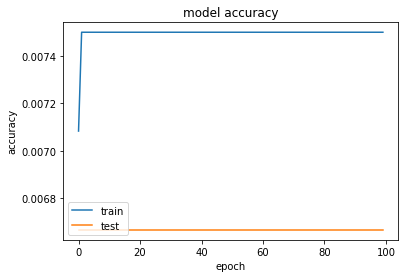

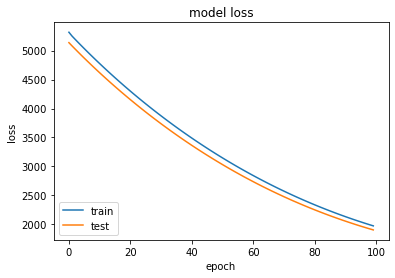

In [26]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()